In [1]:
from circuit_knitting.cutting import partition_problem
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp, PauliList
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers.cobyla import COBYLA
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals
from IPython.display import clear_output
from loss_optimization.accuracy_score import encode_y

/var/folders/3j/3p_dzlvs1nsdfryf9hm7gjnr0000gn/T/ipykernel_93164/2931032580.py:9: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
seed = 100

## Data Loading

In [3]:
# Load data
data = pd.read_csv("diabetes_normalized.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.66872,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.40918,-2.094395,0


In [4]:
y = data["Outcome"]
x = data.drop(["Outcome"], axis=1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [6]:
x_train_A = x_train.iloc[:, :4]
x_train_B = x_train.iloc[:, 4:]

In [7]:
x_test_A = x_test.iloc[:, :4]
x_test_B = x_test.iloc[:, 4:]

In [8]:
new_y_train = encode_y(y_train)
new_y_test = encode_y(y_test)

## Data Embedding

In [9]:
# Data Embedding - Angle Encoding
def angle_encoding(feature_dims: int):
    embedding = QuantumCircuit(feature_dims)
    feature_param = ParameterVector("Theta", feature_dims)
    for qubit in range(feature_dims):
        embedding.ry(feature_param[qubit], qubit)
    return embedding, feature_param

In [10]:
embedding, feature_params = angle_encoding(4)

## Tensor Network

In [11]:
from tensor_network.ttn import TTN

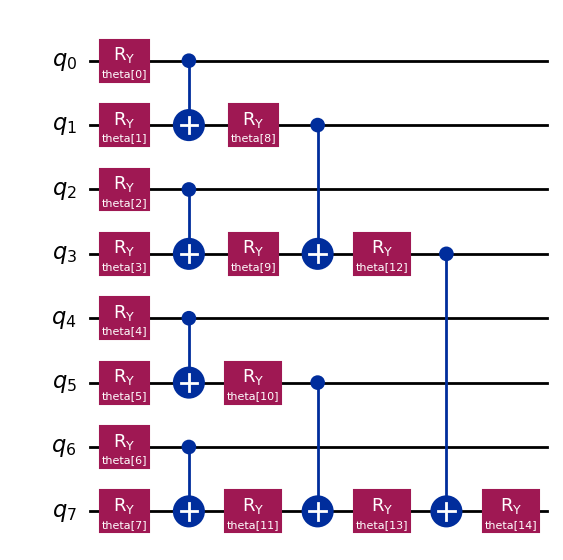

In [12]:
ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
ttn.draw("mpl", style="iqp")

In [13]:
# ttn.parameters

## Circuit Cutting

In [14]:
observables = PauliList(["ZIIIIIII"])
partitioned_problem = partition_problem(circuit=ttn, partition_labels="AAAABBBB", observables=observables)
sub_circuits = partitioned_problem.subcircuits
sub_observables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [15]:
sub_observables

{'A': PauliList(['IIII']), 'B': PauliList(['ZIII'])}

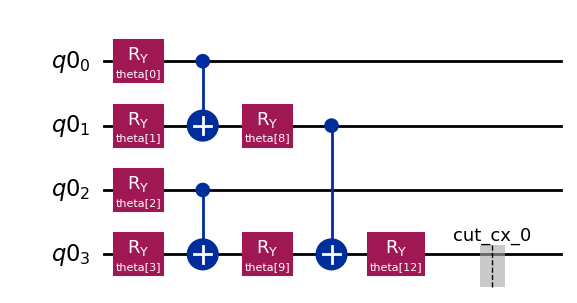

In [16]:
sub_circuits["A"].draw("mpl", style="iqp")

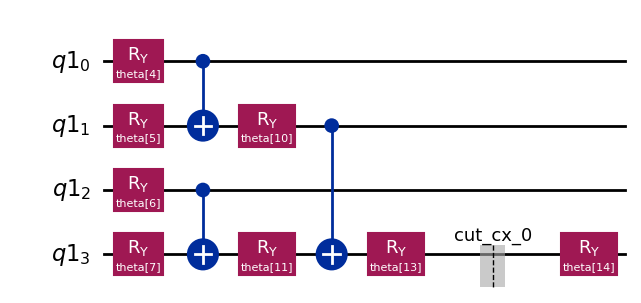

In [17]:
sub_circuits["B"].draw("mpl", style="iqp")

In [18]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 9.0


### Sub Experiments

In [19]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=sub_circuits, observables=sub_observables, num_samples=np.inf
)

In [20]:
# subexperiments
len(subexperiments["A"])

6

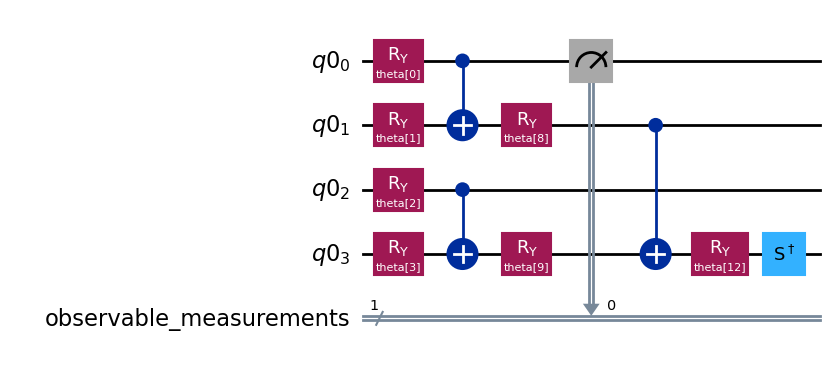

In [21]:
subexperiments["A"][0].draw("mpl", style="iqp")

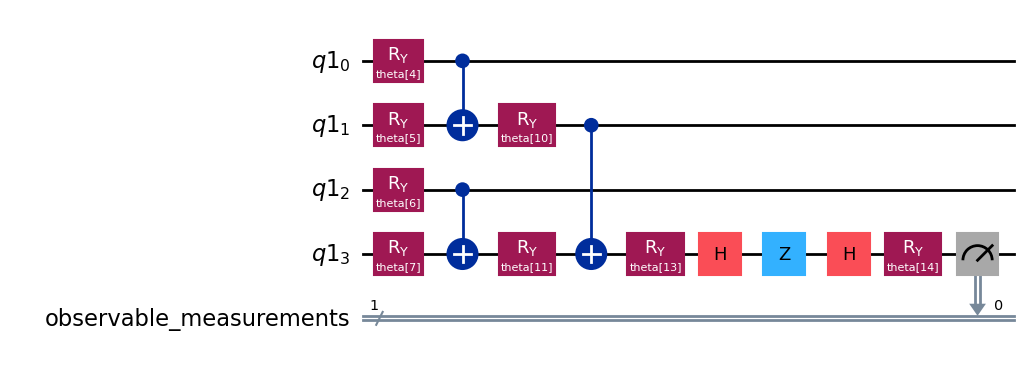

In [22]:
subexperiments["B"][3].draw("mpl", style="iqp")

## Neural Network Training

In [23]:
from qiskit_machine_learning.neural_networks import SamplerQNN, NeuralNetwork
from qiskit_aer.primitives import Sampler
from typing import Callable

In [24]:
sampler = Sampler(transpile_options={"optimization_level": 3}, run_options={"shots": 1024})

### Sampler

In [25]:
from primitives.custom_sampler_qnn import CustomSampler

#### For subexperiments["A"]

In [26]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]
# final_circuits[0].draw("mpl")

In [27]:
sampler_qcnn = CustomSampler(
    circuits=final_circuits, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["A"].parameters,
    input_gradients=False,
)

In [ ]:
weights_A = algorithm_globals.random.random(7)
forward_output = sampler_qcnn.forward(
    input_data=x_train_A,
    weights=weights_A,
)

In [ ]:
# forward output is a dictionary of 6 subex_circ items.
print(f"Output shape for {len(x_train_A)} samples: {forward_output[0].shape}")
print(len(forward_output[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output[i][0] for i in range(6)])}")

In [ ]:
input_grad, weights_grad = sampler_qcnn.backward(
    input_data=x_train_A,
    weights=weights_A
)

In [ ]:
print(f"Output shape for {len(x_train_A)} samples: {weights_grad[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad[i][0] for i in range(6)])}")

#### For subexperiments["B"]

In [28]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [29]:
sampler_qcnn2 = CustomSampler(
    circuits=final_circuits2, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["B"].parameters,
)

In [ ]:
weights_B = algorithm_globals.random.random(8)
forward_output2 = sampler_qcnn2._forward(
    input_data=x_train_B,
    weights=weights_B,
)

In [ ]:
print(f"Output shape for {len(x_train_A)} samples: {forward_output2[0].shape}")
print(len(forward_output2[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output2[i][0] for i in range(6)])}")

In [ ]:
input_grad2, weights_grad2 = sampler_qcnn2._backward(
    input_data=x_train_B,
    weights=weights_B
)

In [ ]:
print(f"Output shape for {len(x_train_B)} samples: {weights_grad2[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad2[i][0] for i in range(6)])}")

## Loss and Optimization

In [30]:
from qiskit_machine_learning.utils.loss_functions import L2Loss
from loss_optimization.custom_cross_entropy_loss import CustomCrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from loss_optimization.objective_func import CustomMultiClassObjectiveFunction
# from loss_optimization.callback import callback
from loss_optimization.optimization import create_objective, minimizer, print_optimizer_results

In [31]:
def callback_spsa(nfev=None, params=None, fval=None, stepsize=None, accepted=None):
    """
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    # objective_func_vals = loss
    global objective_func_vals

    if (nfev % 3) == 0:
        objective_func_vals.append(fval)
        print(f"SPSA Epoch {len(objective_func_vals)}: {fval:.5f}")

def callback_cobyla(weights, obj_func_eval):
    # clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print(f"COBYLA Epoch {len(objective_func_vals)}: {obj_func_eval:.5f}")

In [33]:
objective_func_vals = []
# loss = L2Loss()
loss = CustomCrossEntropyLoss()
# optimizer = COBYLA(maxiter=5)
optimizer = SPSA(maxiter=5, callback=callback_spsa)
# optimizer = GradientDescent(maxiter=2) # This doesn't work yet. The gradient shape doesn't match.

#### Optimizer Result for sub-circuits["A"]

In [34]:
initial_point = np.random.random((7,))
function = CustomMultiClassObjectiveFunction(x_train_A, y_train, sampler_qcnn, loss)

In [35]:
# Optimizer result for 0th circuit for sub-circuit-A
optimizer_result_A0 = minimizer(function, function.objective0, function.gradient0, initial_point, optimizer)
optimizer_result_A1 = minimizer(function, function.objective1, function.gradient1, initial_point, optimizer)
optimizer_result_A2 = minimizer(function, function.objective2, function.gradient2, initial_point, optimizer)
optimizer_result_A3 = minimizer(function, function.objective3, function.gradient3, initial_point, optimizer)
optimizer_result_A4 = minimizer(function, function.objective4, function.gradient4, initial_point, optimizer)
optimizer_result_A5 = minimizer(function, function.objective5, function.gradient5, initial_point, optimizer)

/Users/saashajoshi/anaconda3/envs/qiskit_x86/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/saashajoshi/anaconda3/envs/qiskit_x86/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


SPSA Epoch 1: 2017.20249
SPSA Epoch 2: 1796.41939
SPSA Epoch 3: 1722.68946
SPSA Epoch 4: 1697.97726
SPSA Epoch 5: 1678.27687
{   'fun': 1678.276871894209,
    'jac': None,
    'nfev': 15,
    'nit': 5,
    'njev': None,
    'x': array([-0.88535767,  0.53916205, -0.02939879,  0.47010934,  0.42312291,
       -0.31246783,  1.71759114])}
SPSA Epoch 6: 2005.86310
SPSA Epoch 7: 1785.29531
SPSA Epoch 8: 1721.32587
SPSA Epoch 9: 1692.43914
SPSA Epoch 10: 1679.83185
{   'fun': 1679.8318508928853,
    'jac': None,
    'nfev': 15,
    'nit': 5,
    'njev': None,
    'x': array([-0.89384804, -0.13572443, -0.09475481,  1.28411771,  0.96585009,
       -0.70167567,  1.25648341])}
SPSA Epoch 11: 527.16605
SPSA Epoch 12: 526.31627
SPSA Epoch 13: 507.59316
SPSA Epoch 14: 472.29056
SPSA Epoch 15: 461.45140
{   'fun': 461.45139507154744,
    'jac': None,
    'nfev': 15,
    'nit': 5,
    'njev': None,
    'x': array([-0.83579222,  0.94268562,  1.45363803, -0.22365791,  0.98976977,
        1.06173338, -0.0

In [36]:
optimizer_results_A = [optimizer_result_A0, optimizer_result_A1, optimizer_result_A2, optimizer_result_A3, optimizer_result_A4, optimizer_result_A5]

In [37]:
# Print results from 6 sub-experiments of sub-circuit-A
for opt_result in optimizer_results_A:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [-0.88535767  0.53916205 -0.02939879  0.47010934  0.42312291 -0.31246783
  1.71759114]
The final value of the minimization: 1678.276871894209
The final gradient of the minimization: None
The total number of function evaluations: 15
The total number of gradient evaluations: None
The total number of iterations: 5
New params (The final point of the minimization): [-0.89384804 -0.13572443 -0.09475481  1.28411771  0.96585009 -0.70167567
  1.25648341]
The final value of the minimization: 1679.8318508928853
The final gradient of the minimization: None
The total number of function evaluations: 15
The total number of gradient evaluations: None
The total number of iterations: 5
New params (The final point of the minimization): [-0.83579222  0.94268562  1.45363803 -0.22365791  0.98976977  1.06173338
 -0.0534474 ]
The final value of the minimization: 461.45139507154744
The final gradient of the minimization: None
The total number of function evalua

Text(0.5, 1.0, 'Training loss')

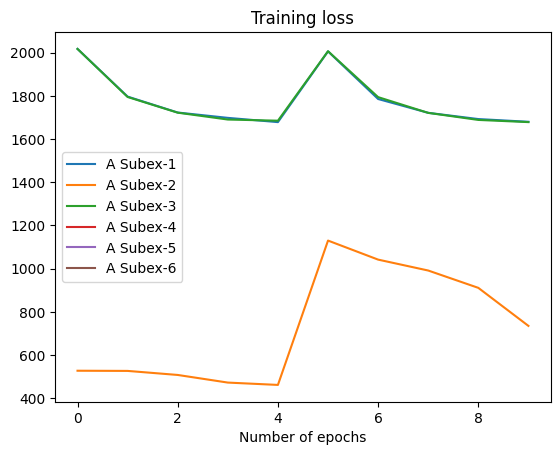

In [38]:
plt.plot(objective_func_vals[:10], label="A Subex-1")
plt.plot(objective_func_vals[10:20], label="A Subex-2")
plt.plot(objective_func_vals[20:30], label="A Subex-3")
plt.plot(objective_func_vals[30:40], label="A Subex-4")
plt.plot(objective_func_vals[40:50], label="A Subex-5")
plt.plot(objective_func_vals[50:60], label="A Subex-6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [39]:
objective_func_vals.clear()
objective_func_vals

[]

#### Optimizer Result for sub-circuits["B"]

In [40]:
initial_point2 = np.random.random((8,))
function2 = CustomMultiClassObjectiveFunction(x_train_B, y_train, sampler_qcnn2, loss)

In [41]:
# Optimizer result for 0th circuit for sub-circuit-B
optimizer_result_B0 = minimizer(function2, function2.objective0, function2.gradient0, initial_point2, optimizer)
optimizer_result_B1 = minimizer(function2, function2.objective1, function2.gradient1, initial_point2, optimizer)
optimizer_result_B2 = minimizer(function2, function2.objective2, function2.gradient2, initial_point2, optimizer)
optimizer_result_B3 = minimizer(function2, function2.objective3, function2.gradient3, initial_point2, optimizer)
optimizer_result_B4 = minimizer(function2, function2.objective4, function2.gradient4, initial_point2, optimizer)
optimizer_result_B5 = minimizer(function2, function2.objective5, function2.gradient5, initial_point2, optimizer)

SPSA Epoch 1: 2613.94362
SPSA Epoch 2: 1982.65803
SPSA Epoch 3: 1956.49850
SPSA Epoch 4: 1762.13809
SPSA Epoch 5: 1742.78458
{   'fun': 1742.784577585442,
    'jac': None,
    'nfev': 15,
    'nit': 5,
    'njev': None,
    'x': array([ 0.9538272 ,  0.08183514,  1.48212395,  0.45501885,  1.25978738,
        0.46624862,  0.26188325, -1.42175622])}
SPSA Epoch 6: 2774.35765
SPSA Epoch 7: 2698.33113
SPSA Epoch 8: 2688.04435
SPSA Epoch 9: 2627.47194
SPSA Epoch 10: 2458.01511
{   'fun': 2458.0151100918865,
    'jac': None,
    'nfev': 15,
    'nit': 5,
    'njev': None,
    'x': array([-0.00726522, -0.28943792,  1.36502571, -0.64253619, -0.65419547,
        1.14982251,  0.05190601, -1.12220887])}
SPSA Epoch 11: 3544.33540
SPSA Epoch 12: 3463.84729
SPSA Epoch 13: 2396.62932
SPSA Epoch 14: 2027.74046
SPSA Epoch 15: 1951.65414
{   'fun': 1951.6541412383817,
    'jac': None,
    'nfev': 15,
    'nit': 5,
    'njev': None,
    'x': array([-0.83433493, -0.40957662,  0.72065908,  0.18780079, -0.003

In [42]:
optimizer_results_B = [optimizer_result_B0, optimizer_result_B1, optimizer_result_B2, optimizer_result_B3, optimizer_result_B4, optimizer_result_B5]

In [43]:
# Print results from 6 sub-experiments of sub-circuit-B
for opt_result in optimizer_results_B:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [ 0.9538272   0.08183514  1.48212395  0.45501885  1.25978738  0.46624862
  0.26188325 -1.42175622]
The final value of the minimization: 1742.784577585442
The final gradient of the minimization: None
The total number of function evaluations: 15
The total number of gradient evaluations: None
The total number of iterations: 5
New params (The final point of the minimization): [-0.00726522 -0.28943792  1.36502571 -0.64253619 -0.65419547  1.14982251
  0.05190601 -1.12220887]
The final value of the minimization: 2458.0151100918865
The final gradient of the minimization: None
The total number of function evaluations: 15
The total number of gradient evaluations: None
The total number of iterations: 5
New params (The final point of the minimization): [-0.83433493 -0.40957662  0.72065908  0.18780079 -0.00385748  0.05334265
 -0.54761304 -0.53423057]
The final value of the minimization: 1951.6541412383817
The final gradient of the minimization: None

Text(0.5, 1.0, 'Training loss')

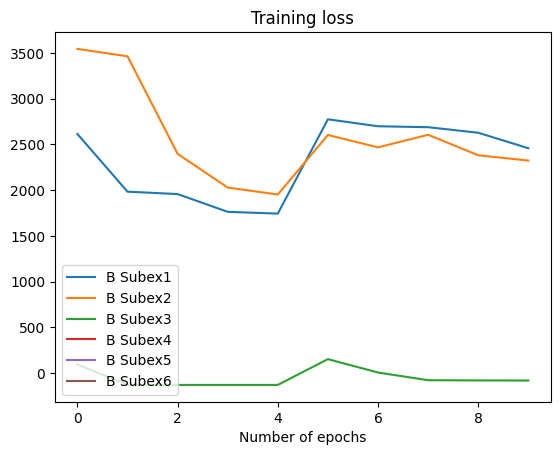

In [44]:
plt.plot(objective_func_vals[:10], label="B Subex1")
plt.plot(objective_func_vals[10:20], label="B Subex2")
plt.plot(objective_func_vals[20:30], label="B Subex3")
plt.plot(objective_func_vals[30:40], label="B Subex4")
plt.plot(objective_func_vals[40:50], label="B Subex5")
plt.plot(objective_func_vals[50:60], label="B Subex6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [45]:
objective_func_vals.clear()
objective_func_vals

[]

### At this point, the training is complete. 
We have 12 lists of 7 or 8 parameter values that will now be used to make predictions on the test cases. 
New subcircuits will be built using these parameter values and then their results will be used to reconstruct expectation values. This process will occur for all the inputs in the test set.


Let us think of the training process as a box that we can tune/edit while training on the train set. However, once the training process is complete, the box is locked and provided to the user. The user can now send test data to the box and get its desired output.

However, in the case of circuit cutting, instead of having one box, we have multiple boxes. In our case, we have a total of 12 boxes (6 boxes per cut). These 12 boxes are trained independently of each other and locked after the training process is complete. The user, now, instead of sending the test data to one box, splits it into 2 parts that are sent to these 12 boxes. The 12 boxes produce quasi-probability distributions respective to the circuits they implement which are then reconstructed to produce the expectation value according to the test input. This process is repeated for every data point in the test dataset.

## Reconstruct Expectation Values and Testing

In [46]:
from circuit_knitting.cutting import reconstruct_expectation_values
from qiskit_aer.primitives import Sampler
from qiskit.primitives import SamplerResult
from loss_optimization.accuracy_score import get_accuracy_score, predict
from circuit_cut.reconstruct_exp_val import get_subcircuit_results, get_dict_sampler_results, get_reconstructed_expvals

### Reconstructing for train accuracy

In [ ]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [ ]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [48]:
train_results_A = get_subcircuit_results(x_train_A, final_circuits, optimizer_results_A, sampler)
train_results_B = get_subcircuit_results(x_train_B, final_circuits2, optimizer_results_B, sampler)

In [49]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 537 train data inputs
A_dict = get_dict_sampler_results(x_train_A, subexperiments["A"], train_results_A)
B_dict = get_dict_sampler_results(x_train_B, subexperiments["B"], train_results_B)

In [50]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [51]:
y_predicted = predict(reconstructed_expvals)

In [52]:
# accuracy_score function encodes y_train inside the function. Therefore, pass original y_train here.
train_score1 = get_accuracy_score(new_y_train, y_predicted)
train_score2 = get_accuracy_score(y_train, y_predicted)
print(f"The Train Accuracy of the model is: {train_score1, train_score2}")

The Train Accuracy of the model is: (0.6052141527001862, 0.6052141527001862)


### Reconstructing for test accuracy

In [ ]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [ ]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [ ]:
test_results_A = get_subcircuit_results(x_test_A, final_circuits, optimizer_results_A, sampler)
test_results_B = get_subcircuit_results(x_test_B, final_circuits2, optimizer_results_B, sampler)

In [ ]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 231 test data inputs
A_dict = get_dict_sampler_results(x_test_A, subexperiments["A"], test_results_A)
B_dict = get_dict_sampler_results(x_test_B, subexperiments["B"], test_results_B)

In [ ]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [ ]:
y_predicted = predict(reconstructed_expvals)

In [ ]:
# Pass original y_test here.
test_score1 = get_accuracy_score(new_y_test, y_predicted)
test_score2 = get_accuracy_score(y_test, y_predicted)
print(f"The Test Accuracy of the model is: {test_score1, test_score2}")

In [ ]:
# brand_new_y_train = new_y_train.replace({-1: 1, 1: -1})
# brand_new_y_test = new_y_test.replace({-1: 1, 1: -1})

## Test original circuit for x_test[0]

In [64]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator

In [65]:
embedding, features = angle_encoding(8)
new_ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
org_circuit = embedding.compose(new_ttn)
# final_circuit.draw()

In [66]:
# gpu_simulator = AerSimulator(device='GPU')
# simulator = AerSimulator()
# backend = BackendEstimator(backend=simulator)

In [66]:
observable = SparsePauliOp(["ZIIIIIII"])
estimator_qnn = EstimatorQNN(
    # estimator=backend,
    circuit=org_circuit,
    observables=observable,
    input_params=features.params,
    weight_params=new_ttn.parameters,
)

In [67]:
weights = np.random.random(len(new_ttn.parameters))

In [68]:
# Forward pass
output = estimator_qnn.forward(x_train, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 768 samples: (537, 1)
Output of the forward pass for first sample: [0.08623017]


In [ ]:
# Backward pass
_, weights_grad = estimator_qnn.backward(x_train, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

In [69]:
initial_point = np.random.random((len(new_ttn.parameters),))

In [ ]:
# def encode_y(y):
#     y_encoded = y.replace({0: -1, 1: 1})
#     return y_encoded

# new_y = encode_y(y_test)
# new_y_train = encode_y(y_train)

In [70]:
classifier = NeuralNetworkClassifier(
    estimator_qnn,
    # optimizer=SPSA(maxiter=10, callback=callback),
    optimizer=COBYLA(maxiter=10),
    initial_point=initial_point,
)

In [73]:
print(len(x_test.values), len(new_y_test.values))

231 231


In [72]:
classifier.fit(x_train, new_y_train)

In [ ]:
# plt.plot(objective_func_vals)
# plt.xlabel("Number of epochs")
# plt.title("Training loss")

In [74]:
y_test_pred = classifier.predict(x_test)
# y_test_pred

In [75]:
classifier.score(x_test, new_y_test)

0.5021645021645021

In [76]:
classifier.score(x_train, new_y_train)

0.48044692737430167